# The Hydra Game: Hercules vs. the Hydra

In Greek mythology, the Hydra regrows heads when Hercules cuts them off. The mathematical Hydra game, introduced by Kirby and Paris (1982), models this as a game on rooted trees.

**Rules:**
1. The Hydra is a rooted tree. Each leaf is a "head."
2. At step *n*, Hercules cuts off one head (removes a leaf node).
3. If the head's parent is the **root**, the head is simply removed — no regrowth.
4. If the head's parent is **not the root**, *n* copies of the parent subtree (after removal) are added to the grandparent. The Hydra grows back stronger.

**The remarkable theorem:** Hercules *always* wins — the game terminates no matter which head he cuts, no matter how many regrow. This is proven using ordinal arithmetic and cannot be proved in Peano arithmetic.

We'll demo the full game starting from the tree `root → c → b → h`.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

class HydraNode:
    """A node in the Hydra tree."""
    _counter = 0
    
    def __init__(self, label: str = ""):
        HydraNode._counter += 1
        self.id = HydraNode._counter
        self.label = label
        self.children: list['HydraNode'] = []
    
    def is_leaf(self) -> bool:
        return len(self.children) == 0
    
    def count_heads(self) -> int:
        if self.is_leaf():
            return 1
        return sum(c.count_heads() for c in self.children)
    
    def count_nodes(self) -> int:
        return 1 + sum(c.count_nodes() for c in self.children)
    
    def __repr__(self):
        if self.is_leaf():
            return self.label
        kids = ", ".join(repr(c) for c in self.children)
        return f"{self.label}[{kids}]"


def build_initial_hydra() -> HydraNode:
    """Build the starting tree: root -> c -> b -> h"""
    HydraNode._counter = 0
    root = HydraNode("root")
    c = HydraNode("c")
    b = HydraNode("b")
    h = HydraNode("h")
    b.children.append(h)
    c.children.append(b)
    root.children.append(c)
    return root


def find_leftmost_leaf(node: HydraNode, parent=None, grandparent=None):
    """Find the leftmost leaf and return (leaf, parent, grandparent)."""
    if node.is_leaf():
        return (node, parent, grandparent)
    return find_leftmost_leaf(node.children[0], node, parent)


def hydra_step(root: HydraNode, step_num: int) -> str:
    """Perform one step of the Hydra game. Returns a description of what happened."""
    if not root.children:
        return "Hydra is dead! Hercules wins!"
    
    leaf, parent, grandparent = find_leftmost_leaf(root)
    
    # Remove the leaf from its parent
    parent.children.remove(leaf)
    
    if parent is root:
        # Head's parent is root: just remove, no regrowth
        desc = f"Step {step_num}: Cut head '{leaf.label}' (child of root). No regrowth."
    else:
        # Head's parent is NOT root: n copies of parent subtree added to grandparent
        desc = f"Step {step_num}: Cut head '{leaf.label}'. {step_num} copies of subtree regrow."
        for _ in range(step_num):
            grandparent.children.append(deepcopy(parent))
    
    # Clean up: remove parent if it became childless and is not root
    # (parent stays as a leaf — it's now a new head)
    
    return desc


# Build and display initial hydra
root = build_initial_hydra()
print(f"Initial Hydra: {root}")
print(f"Heads: {root.count_heads()}, Total nodes: {root.count_nodes()}")

Initial Hydra: root[c[b[h]]]
Heads: 1, Total nodes: 4


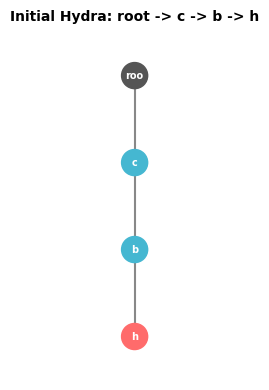

Red nodes = heads (leaves). Blue = internal nodes. Gray = root.
The Hydra has 1 head(s) and 4 node(s).


In [2]:
def count_leaves(node):
    """Count leaf nodes in a subtree."""
    if node.is_leaf():
        return 1
    return sum(count_leaves(c) for c in node.children)


def layout_tree(node, positions=None, edges=None, leaf_counter=None, spacing=0.7, y=0):
    """Compute (x, y) positions using a leaf-slot layout.
    
    Each leaf gets a unique x-slot. Parents are centered above their children.
    This guarantees no overlap regardless of tree shape.
    Uses id(node) as key to handle deepcopy'd nodes with duplicate .id fields.
    """
    if positions is None:
        positions = {}
        edges = []
        leaf_counter = [0]  # mutable counter shared across recursion
    
    node_key = id(node)
    
    if node.is_leaf():
        x = leaf_counter[0] * spacing
        leaf_counter[0] += 1
        positions[node_key] = (x, y, node.label, True)
        return positions, edges, x
    
    child_xs = []
    for child in node.children:
        _, _, cx = layout_tree(child, positions, edges, leaf_counter, spacing, y - 1.2)
        child_xs.append((cx, id(child)))
    
    # Parent x = center of its children
    x = (min(cx for cx, _ in child_xs) + max(cx for cx, _ in child_xs)) / 2
    positions[node_key] = (x, y, node.label, False)
    
    # Add edges from parent to children
    for _, child_key in child_xs:
        cx, cy = positions[child_key][0], positions[child_key][1]
        edges.append((x, y, cx, cy))
    
    return positions, edges, x


def draw_tree(root, ax, title=""):
    """Draw a tree on the given axes with proper bounds."""
    n_heads = root.count_heads()
    # Tighter spacing for very wide trees, wider for small ones
    spacing = max(0.45, min(0.9, 7.0 / max(n_heads, 1)))
    positions, edges, _ = layout_tree(root, spacing=spacing)
    
    # Draw edges
    for x1, y1, x2, y2 in edges:
        ax.plot([x1, x2], [y1, y2], '-', color='#888', linewidth=1.5, zorder=1)
    
    # Draw nodes
    r = 0.18
    for nkey, (x, y, label, is_leaf) in positions.items():
        if label == "root":
            color = '#555'
        elif is_leaf:
            color = '#ff6b6b'
        else:
            color = '#45b7d1'
        
        circle = plt.Circle((x, y), r, color=color, zorder=3)
        ax.add_patch(circle)
        ax.text(x, y, label[:3], ha='center', va='center',
                fontsize=7, fontweight='bold', color='white', zorder=4)
    
    # Set axis limits from actual positions with generous margins
    if positions:
        xs = [p[0] for p in positions.values()]
        ys = [p[1] for p in positions.values()]
        x_margin = max(0.6, (max(xs) - min(xs)) * 0.08 + 0.5)
        y_margin = 0.6
        ax.set_xlim(min(xs) - x_margin, max(xs) + x_margin)
        ax.set_ylim(min(ys) - y_margin, max(ys) + y_margin)
    
    ax.set_aspect('equal')
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=10, fontweight='bold', pad=8)


# Visualize the initial tree
root = build_initial_hydra()
fig, ax = plt.subplots(figsize=(6, 4))
draw_tree(root, ax, title="Initial Hydra: root -> c -> b -> h")
plt.tight_layout()
plt.show()
print("Red nodes = heads (leaves). Blue = internal nodes. Gray = root.")
print(f"The Hydra has {root.count_heads()} head(s) and {root.count_nodes()} node(s).")

## Step-by-step game

Hercules always cuts the **leftmost head**. At step *n*, if the head's parent is not the root, *n* copies of the parent subtree regrow from the grandparent. Let's watch the full game.

In [3]:
# Run the full game, collecting snapshots for visualization
root = build_initial_hydra()
snapshots = [(deepcopy(root), "Initial Hydra", root.count_heads())]

step = 0
while root.children:  # game ends when root has no children
    step += 1
    desc = hydra_step(root, step)
    heads = root.count_heads() if root.children else 0
    snapshots.append((deepcopy(root), desc, heads))
    print(f"{desc}  |  Heads remaining: {heads}")
    if step > 100:  # safety cap
        print("(stopping after 100 steps)")
        break

print(f"\nGame over! Hercules won in {step} steps.")
print(f"Total snapshots: {len(snapshots)}")

Step 1: Cut head 'h'. 1 copies of subtree regrow.  |  Heads remaining: 2
Step 2: Cut head 'b'. 2 copies of subtree regrow.  |  Heads remaining: 3
Step 3: Cut head 'b'. 3 copies of subtree regrow.  |  Heads remaining: 6
Step 4: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 5
Step 5: Cut head 'b'. 5 copies of subtree regrow.  |  Heads remaining: 10
Step 6: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 9
Step 7: Cut head 'b'. 7 copies of subtree regrow.  |  Heads remaining: 16
Step 8: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 15
Step 9: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 14
Step 10: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 13
Step 11: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 12
Step 12: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 11
Step 13: Cut head 'c' (child of root). No regrowth.  |  Heads remaining: 10
Step 14: Cut head 'c' (child of

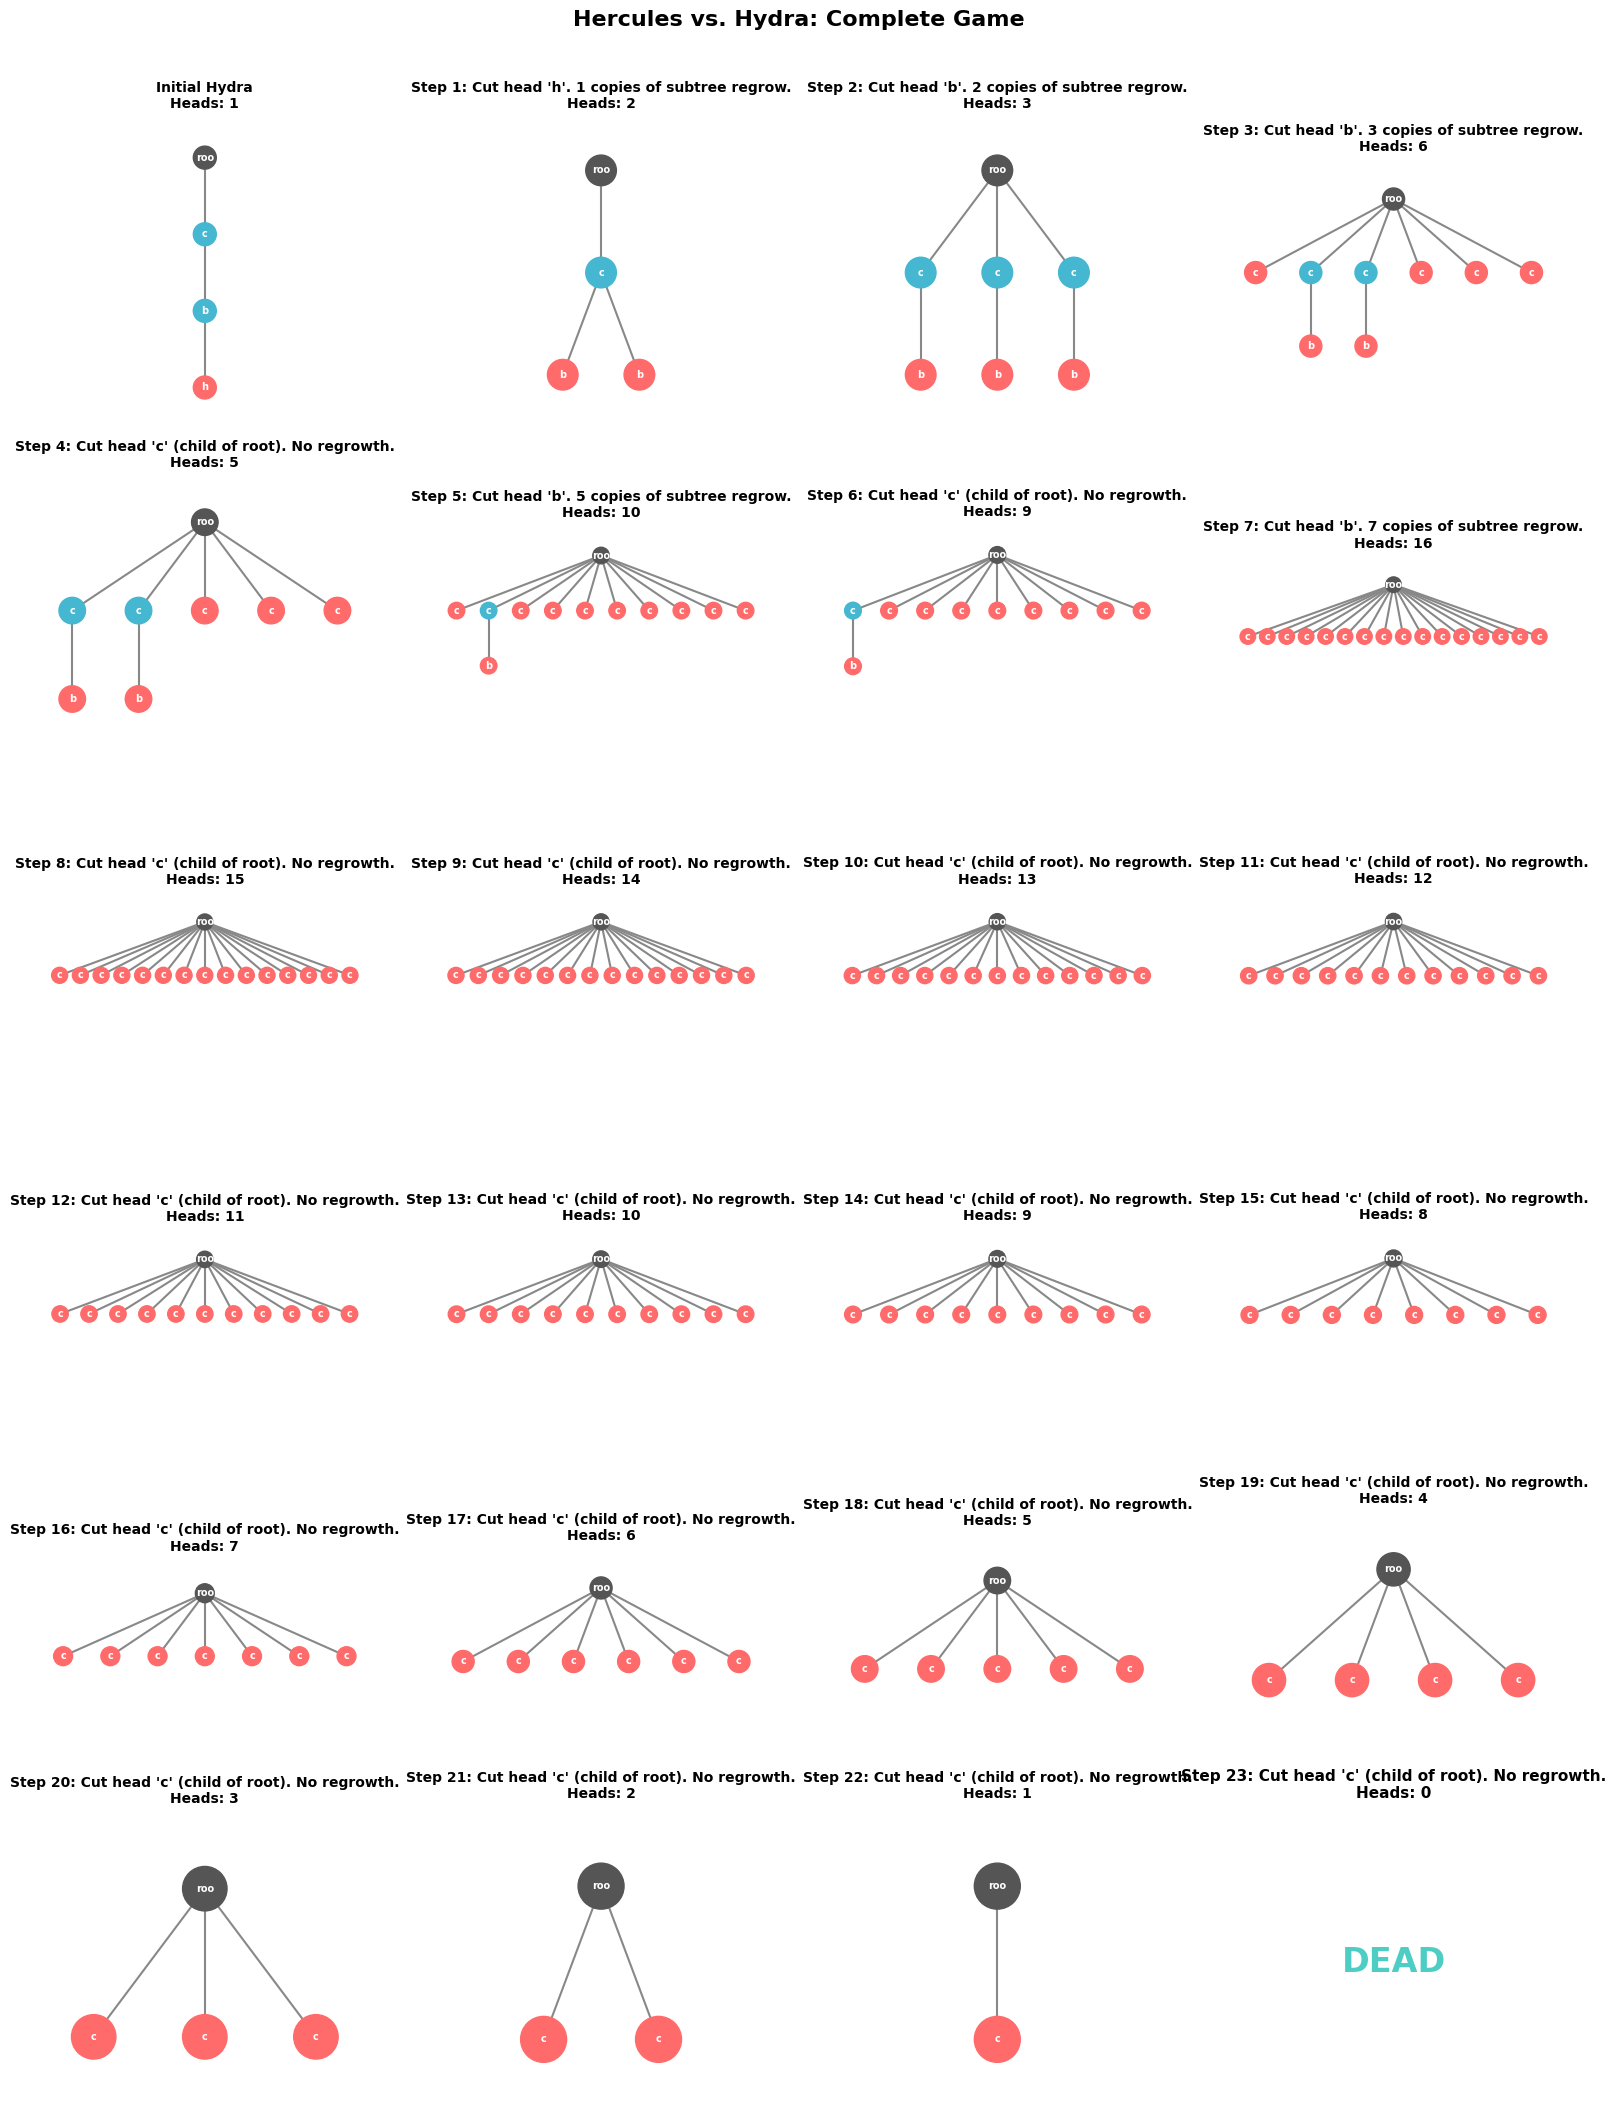

The Hydra grew as many as 16 heads before Hercules defeated it.


In [4]:
# Visualize every step of the game
n_steps = len(snapshots)
cols = 4
rows = (n_steps + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3.5))
axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes.flatten()

for i, (tree, desc, heads) in enumerate(snapshots):
    ax = axes[i]
    short_desc = desc if len(desc) < 55 else desc[:52] + "..."
    title = f"{short_desc}\nHeads: {heads}"
    if tree.children:
        draw_tree(tree, ax, title=title)
    else:
        ax.text(0.5, 0.5, "DEAD", ha='center', va='center',
                fontsize=24, fontweight='bold', color='#4ecdc4',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=11, fontweight='bold', pad=8)
        ax.axis('off')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Hercules vs. Hydra: Complete Game", fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()
print(f"The Hydra grew as many as {max(s[2] for s in snapshots)} heads before Hercules defeated it.")

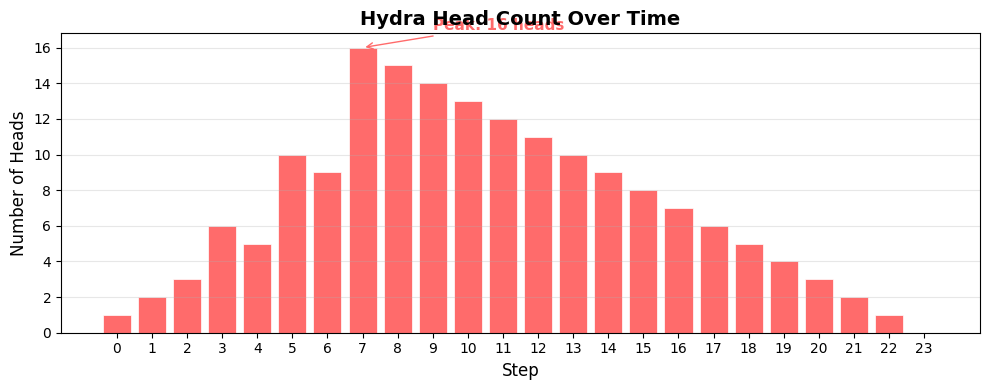

Despite explosive growth, the head count eventually reaches zero.


In [5]:
# Plot head count over time
steps = list(range(len(snapshots)))
head_counts = [s[2] for s in snapshots]

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(steps, head_counts, color=['#ff6b6b' if h > 0 else '#4ecdc4' for h in head_counts],
       edgecolor='white', linewidth=0.5)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Number of Heads', fontsize=12)
ax.set_title('Hydra Head Count Over Time', fontsize=14, fontweight='bold')
ax.set_xticks(steps)
ax.grid(axis='y', alpha=0.3)

# Annotate peak
peak_step = head_counts.index(max(head_counts))
peak_val = max(head_counts)
ax.annotate(f'Peak: {peak_val} heads', xy=(peak_step, peak_val),
            xytext=(peak_step + 2, peak_val + 1),
            arrowprops=dict(arrowstyle='->', color='#ff6b6b'),
            fontsize=11, color='#ff6b6b', fontweight='bold')

plt.tight_layout()
plt.show()
print("Despite explosive growth, the head count eventually reaches zero.")

### Animated Walkthrough

Rendered 24 frames.



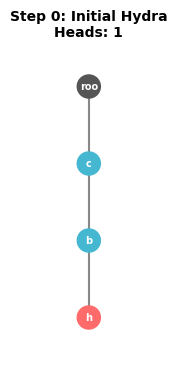

In [6]:
import matplotlib.pyplot as plt
import io
import base64
import json as _json
import random
from IPython.display import display, HTML

# Render each game snapshot as a frame
frames_b64 = []
for i, (tree, desc, heads) in enumerate(snapshots):
    fig, ax = plt.subplots(figsize=(10, 4))
    if tree.children:
        draw_tree(tree, ax, title=f"Step {i}: {desc}\nHeads: {heads}")
    else:
        ax.text(0.5, 0.55, "HYDRA DEFEATED!", ha='center', va='center',
                fontsize=28, fontweight='bold', color='#4ecdc4',
                transform=ax.transAxes)
        ax.text(0.5, 0.35, f"Hercules won in {len(snapshots)-1} steps",
                ha='center', va='center', fontsize=14, color='#888',
                transform=ax.transAxes)
        ax.set_title(f"Step {i}: {desc}", fontsize=11, fontweight='bold', pad=8)
        ax.axis('off')
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    plt.close(fig)
    buf.seek(0)
    frames_b64.append(base64.b64encode(buf.read()).decode('ascii'))

assert len(frames_b64) >= 3, f"Too few frames ({len(frames_b64)})"
assert len(frames_b64) <= 50, f"Too many frames ({len(frames_b64)})"
print(f"Rendered {len(frames_b64)} frames.")

# --- Player ---
uid = f"ap{random.randint(10000, 99999)}"
n_frames = len(frames_b64)

html_tpl = """
<div id="__UID__" style="text-align:center; font-family:-apple-system,BlinkMacSystemFont,'Segoe UI',sans-serif; max-width:820px; margin:0 auto;">
  <style>
    #__UID__ .ap-frame {
      background:#fafafa; border:1px solid #e0e0e0;
      border-radius:10px; padding:12px; margin-bottom:8px;
    }
    #__UID__ .ap-frame img { max-width:100%; border-radius:6px; display:block; margin:0 auto; }
    #__UID__ .ap-controls { display:flex; justify-content:center; gap:8px; flex-wrap:wrap; }
    #__UID__ .ap-btn {
      padding:8px 16px; border:1px solid #ddd; border-radius:8px;
      background:white; font-size:14px; cursor:pointer; color:#333;
      transition:all 0.15s ease; user-select:none;
    }
    #__UID__ .ap-btn:hover:not(:disabled) { background:#f0f0f0; transform:scale(1.03); }
    #__UID__ .ap-btn:disabled { opacity:0.35; cursor:default; transform:none; }
    #__UID__ .ap-btn:active:not(:disabled) { transform:scale(0.97); }
    #__UID__ .ap-play {
      padding:8px 22px; border:none; border-radius:8px;
      background:#45b7d1; color:white; font-size:14px; font-weight:600;
      cursor:pointer; min-width:120px; transition:all 0.15s ease; user-select:none;
    }
    #__UID__ .ap-play:hover { filter:brightness(0.9); transform:scale(1.03); }
    #__UID__ .ap-play:active { transform:scale(0.97); }
    #__UID__ .ap-slider-row input[type=range] {
      width:80%; accent-color:#45b7d1; cursor:pointer; height:6px;
    }
    #__UID__ .ap-speed-row {
      display:flex; justify-content:center; align-items:center;
      gap:6px; margin-top:10px; flex-wrap:wrap;
    }
    #__UID__ .ap-speed-label {
      font-size:13px; color:#888; font-weight:500; margin-right:2px;
    }
    #__UID__ .ap-speed {
      padding:4px 12px; border:1px solid #ddd; border-radius:6px;
      background:white; font-size:13px; cursor:pointer; color:#555;
      transition:all 0.15s ease; user-select:none;
    }
    #__UID__ .ap-speed:hover { background:#f0f0f0; }
    #__UID__ .ap-speed.active {
      background:#45b7d1; color:white; border-color:#45b7d1; font-weight:600;
    }
  </style>
  <div class="ap-frame">
    <img id="__UID__-img" src="data:image/png;base64,__FIRST_FRAME__">
  </div>
  <div class="ap-slider-row" style="margin:10px 0 4px;">
    <input type="range" id="__UID__-slider" min="0" max="__MAX__" value="0">
  </div>
  <div id="__UID__-label" style="margin:2px 0 14px; font-size:15px; color:#555; font-weight:500;">
    Step 0 / __MAX__
  </div>
  <div class="ap-controls">
    <button class="ap-btn" id="__UID__-back" title="Go back one step">&#9664; Back</button>
    <button class="ap-play" id="__UID__-play" title="Play / Pause">&#9654;  Play</button>
    <button class="ap-btn" id="__UID__-fwd" title="Go forward one step">Next &#9654;</button>
    <button class="ap-btn" id="__UID__-replay" title="Start over from the beginning">&#8635; Replay</button>
  </div>
  <div class="ap-speed-row">
    <span class="ap-speed-label">Speed:</span>
    <button class="ap-speed" data-ms="2000">0.5x</button>
    <button class="ap-speed active" data-ms="1000">1x</button>
    <button class="ap-speed" data-ms="500">2x</button>
    <button class="ap-speed" data-ms="333">3x</button>
    <button class="ap-speed" data-ms="200">5x</button>
  </div>
</div>
"""

js_tpl = """
<script>
(function() {
  var frames = __FRAMES__;
  var cur = 0, playing = false, tmr = null, N = frames.length, MS = 1000;
  var el = function(s) { return document.getElementById('__UID__-' + s); };
  var img = el('img'), sld = el('slider'), lbl = el('label');
  var btnPlay = el('play'), btnBack = el('back'), btnFwd = el('fwd');
  var container = document.getElementById('__UID__');

  function show(i) {
    cur = Math.max(0, Math.min(N - 1, i));
    img.src = 'data:image/png;base64,' + frames[cur];
    sld.value = cur;
    lbl.textContent = 'Step ' + cur + ' / ' + (N - 1);
    btnBack.disabled = (cur === 0);
    btnFwd.disabled = (cur === N - 1);
  }

  function tick() {
    if (!playing || cur >= N - 1) { stopPlay(); return; }
    show(cur + 1);
    tmr = setTimeout(tick, MS);
  }

  function startPlay() {
    if (cur >= N - 1) show(0);
    playing = true;
    btnPlay.innerHTML = '&#9646;&#9646;  Pause';
    btnPlay.style.background = '#e74c3c';
    tmr = setTimeout(tick, MS);
  }

  function stopPlay() {
    playing = false;
    btnPlay.innerHTML = '&#9654;  Play';
    btnPlay.style.background = '#45b7d1';
    if (tmr) { clearTimeout(tmr); tmr = null; }
  }

  btnPlay.onclick = function() { playing ? stopPlay() : startPlay(); };
  btnBack.onclick = function() { stopPlay(); show(cur - 1); };
  btnFwd.onclick = function() { stopPlay(); show(cur + 1); };
  el('replay').onclick = function() { show(0); startPlay(); };
  sld.oninput = function() { stopPlay(); show(parseInt(this.value)); };

  var speedBtns = container.querySelectorAll('.ap-speed');
  for (var i = 0; i < speedBtns.length; i++) {
    speedBtns[i].onclick = (function(btn) {
      return function() {
        MS = parseInt(btn.getAttribute('data-ms'));
        for (var j = 0; j < speedBtns.length; j++)
          speedBtns[j].classList.remove('active');
        btn.classList.add('active');
        if (playing) {
          if (tmr) { clearTimeout(tmr); tmr = null; }
          tmr = setTimeout(tick, MS);
        }
      };
    })(speedBtns[i]);
  }

  show(0);
})();
</script>
"""

player_html = (html_tpl
    .replace('__UID__', uid)
    .replace('__FIRST_FRAME__', frames_b64[0])
    .replace('__MAX__', str(n_frames - 1)))

player_js = (js_tpl
    .replace('__FRAMES__', _json.dumps(frames_b64))
    .replace('__UID__', uid))

display(HTML(player_html + player_js))

## Why Hercules always wins

The proof assigns an **ordinal number** to each tree. The key idea:
- A single leaf has ordinal 0
- A node with children of ordinals $\alpha_1 \geq \alpha_2 \geq \ldots$ has ordinal $\omega^{\alpha_1} + \omega^{\alpha_2} + \ldots$
- Each step of the game **strictly decreases** the ordinal, even when the tree grows
- Since there are no infinite strictly decreasing sequences of ordinals, the game must terminate

The starting tree `root -> c -> b -> h` has ordinal $\omega^{\omega}$ (a tower), which is why even this small tree produces many steps before Hercules wins.